# Notes

This is codifying the examples of manual back prop form the other notebook.

# Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graph_visualization_code import draw_dot

# Time to Build out the Value Object

In [2]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0  # 0 means no effect -  we are assuming that at init, every value does not affect the output
        # by default there is nothing to chain rule - so like at a leaf node
        self._backward = lambda: None # this will do the little piece of chain rule at each node that took inputs and produced outputs - this stores how to chain the output gradient into the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(data=self.data + other.data, _children=(self, other),  _op='+')

        # the backward here should be the function that propagates the gradient
        def _backward():
            """
            local derivative * global derivative (derivative of the final output of the expression w.r.t. out's data)

            local derivative is 1.0, as it is the derivative of an addition

            global derivative is the gradient of our output (i.e. the gradient of the parent)

            Essentially out's grad is copied to self and other, which matches the behavior we saw with addition passing on the derivative
            """
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(data=self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            """
            Again we need: local derivative * global derivative

            local derivative is the other value in the multiplication (i.e. d(x1w1)/d(x1) = w1)

            global derivative is the gradient of our output (i.e. the gradient of the parent)
            """
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        """
        We could write out exponentiation to construct tanh. However, we don't need the most fundamental pieces in the Value object.
        
        We can create functions at arbitrary points of abstraction. They can be complicated functions or very simple functions. Up to us.
        
        The only thing that matters is that we know how to differentiate through any one function. The function from inputs to output can be arbitrarily complex as long as we know how to create the local derivative.

        Thus, we'll directly implement tanh instead of implementing each of its fundamental pieces.
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t, _children=(self, ), _op='tanh')

        def _backward():
            """
            No chain rule here - this is our 'base case' (i.e. derivative of output w.r.t. output)

            So, this is just the derivative of tanh

            Although for semantics, the derivative of tanh is the local derivative and the global derivative is again out.grad

            However, out.grad should be 1 in this case (again - base case)
            """
            self.grad = 1 - t**2 * out.grad
        out._backward = _backward
        
        return out

## Calling _backward() by Hand to Automate Local Derivative + Chain Rule

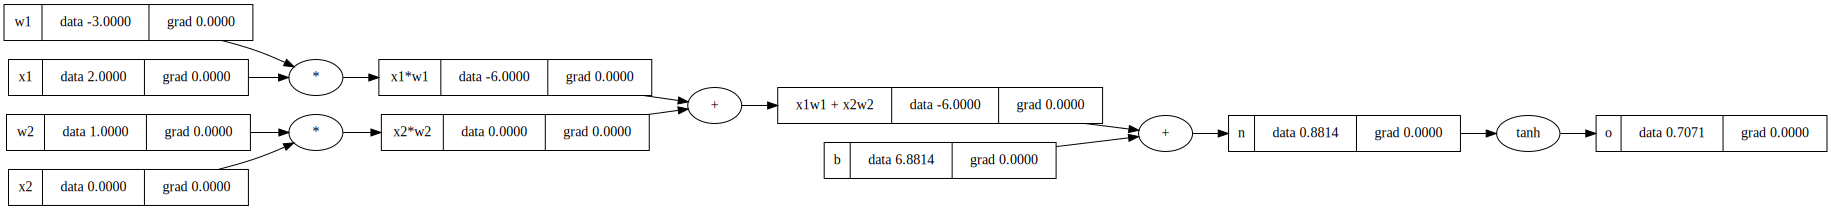

In [3]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (the synaptic strength for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# summation of our weighted inputs with bias (x1w1 + x2w2 + b)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the raw activation of the cell body - without the activation function

o = n.tanh(); o.label = 'o'
draw_dot(o)

So now, we should no longer have to do backprop manually!

In [4]:
o.grad = 1.0 # this our base case

In [5]:
o._backward() # this should propagate our grad through tanh

Redrawing the graph, we should see `n` have a grad value of `0.5`

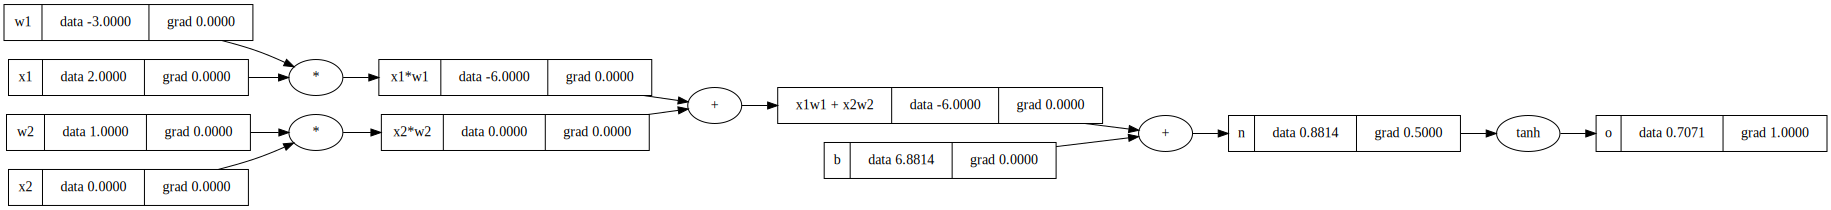

In [6]:
draw_dot(o)

We can repeat this process to continue the backpropagation:

In [7]:
n._backward()

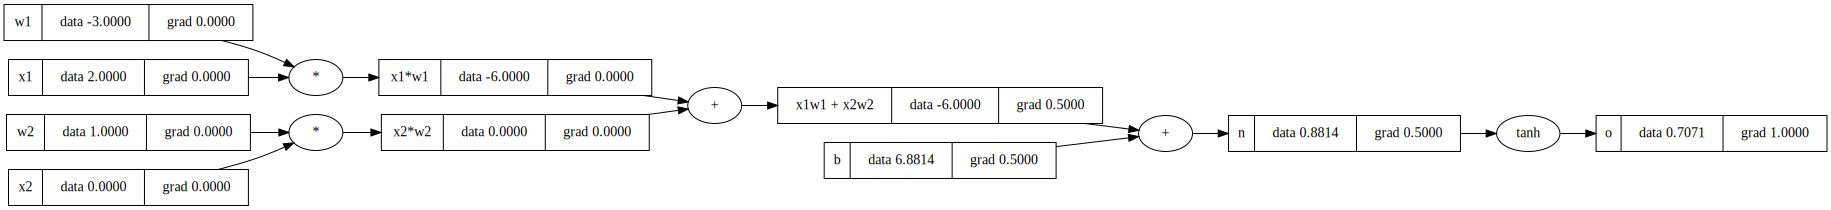

In [8]:
draw_dot(o)

Once again:

In [9]:
b._backward() # this will do nothing since b is a leaf node -> this is none by initialization

In [10]:
x1w1x2w2._backward()

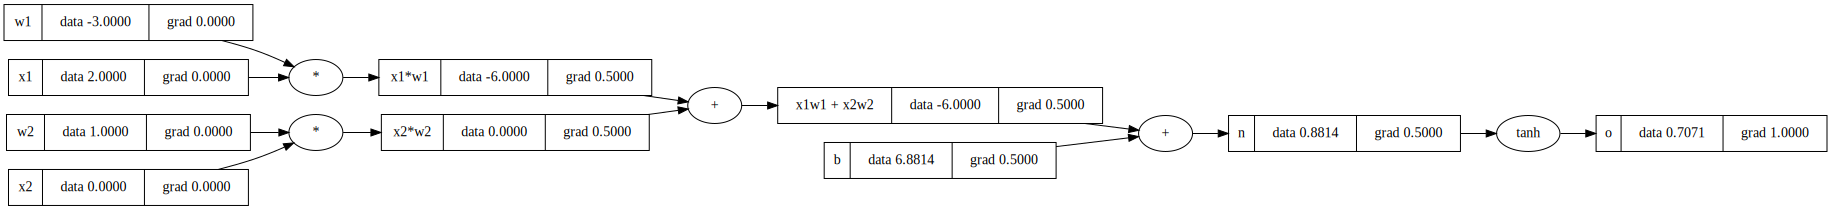

In [11]:
draw_dot(o)

And finally:

In [12]:
x1w1._backward()
x2w2._backward()

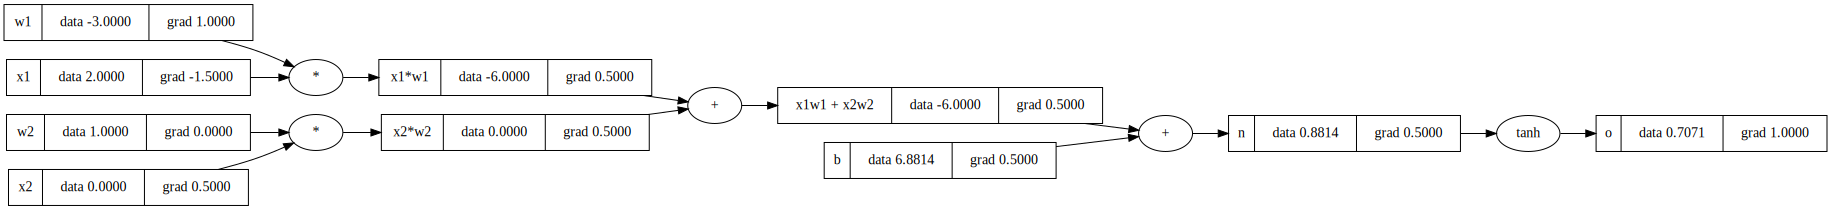

In [13]:
draw_dot(o)

## Automating _backward() with Topological Sort

The final piece to automate backpropagation is to codify the calling of the `_backward()` functions.

It would be useful to reflect for a minute: what are we actually doing?

We've laid out a mathematical expression and we are trying to go backwards through that expression - we never want to call a `_backward()` for any node before we've done everything after it. We need all of the full dependencies to propagate to the node before we can continue backpropagation. This ordering of graphs can be achieved using something called *topological sort*.

*topological sort* is a layouting out of a graph such that all the edges only go from left to right.

Example of topological sort:

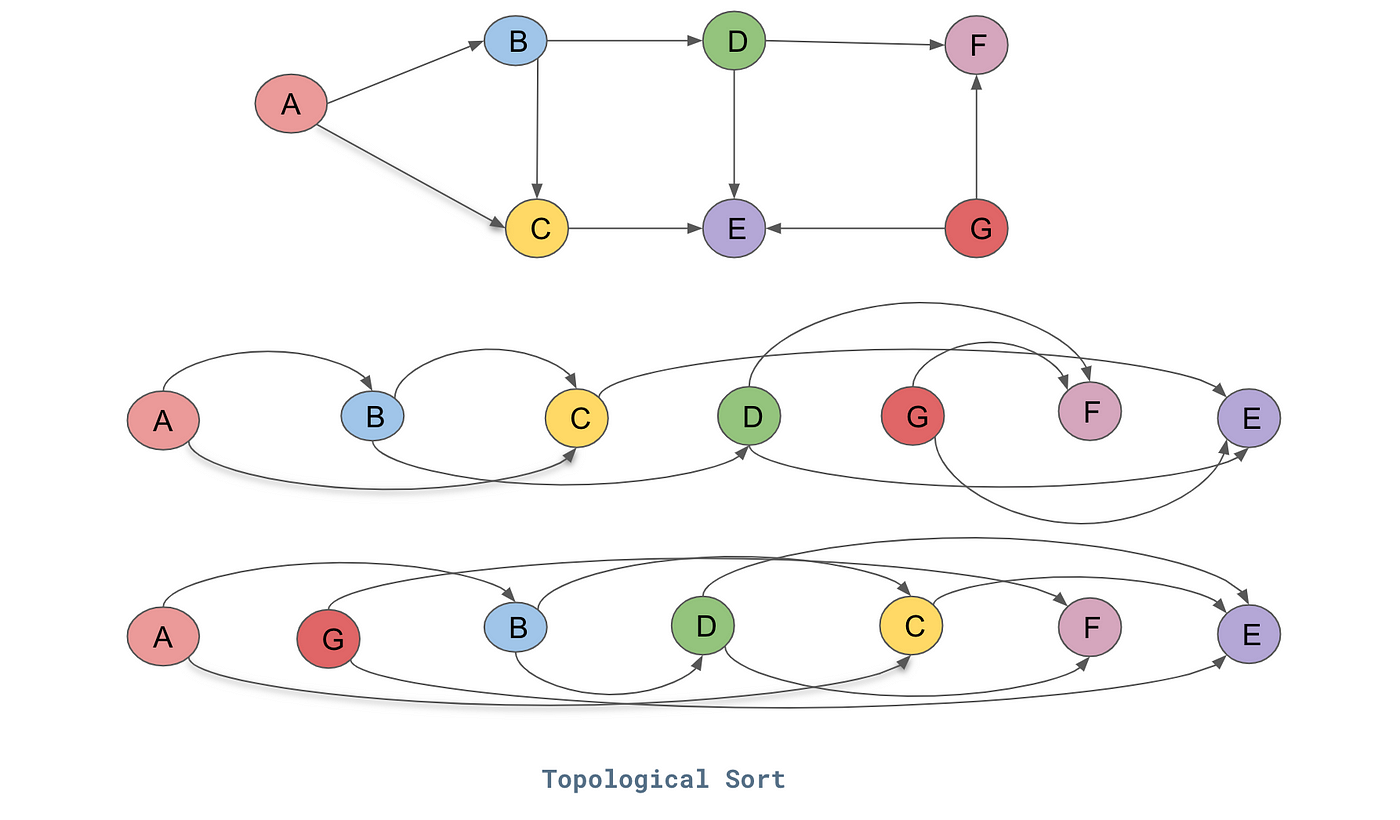

In [20]:
from IPython.display import Image
Image(filename='./topological_sort.png', width=800)

Note: we have to orderings above fulfilling the criteria of edges going only (one way) from left to right.

Topological sort algorithm:

In [21]:
topo = []
visited = set()
def build_topo(v):
    """
    Starting at some root node (in our case the output), we go through all of its kids and lay them out from left to right

    What this does is calling _backward() on all of the nodes in a topological order
    """
    if v not in visited:
        visited.add(v)
        for child in v._prev: # you can think of v._prev as what the root (or current) node point to - it's a little backwards, but we are doing back prop after all!
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

This is the topological order above. We can reset our example and then use the ordering to call `_backward()` programatically.

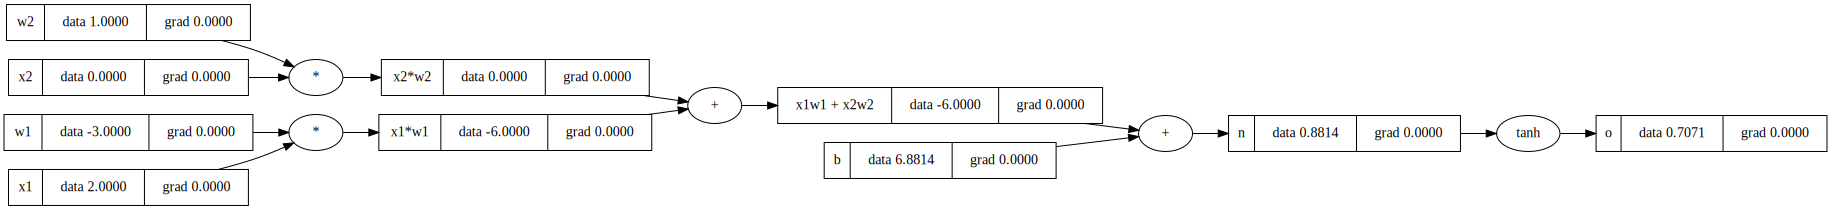

In [29]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (the synaptic strength for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# summation of our weighted inputs with bias (x1w1 + x2w2 + b)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the raw activation of the cell body - without the activation function

o = n.tanh(); o.label = 'o'
draw_dot(o)

In [30]:
o.grad = 1 # need to set up base case gradient

topo = []
visited = set()
def build_topo(v):
    """
    Starting at some root node (in our case the output), we go through all of its kids and lay them out from left to right

    What this does is calling _backward() on all of the nodes in a topological order
    """
    if v not in visited:
        visited.add(v)
        for child in v._prev: # you can think of v._prev as what the root (or current) node point to - the resulting topo is a little backwards, but we are doing back prop after all!
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [31]:
# we need to reverse to start with our output node as the root node
for node in reversed(topo):
    node._backward()

Now we can examine our resulting automated backprop:

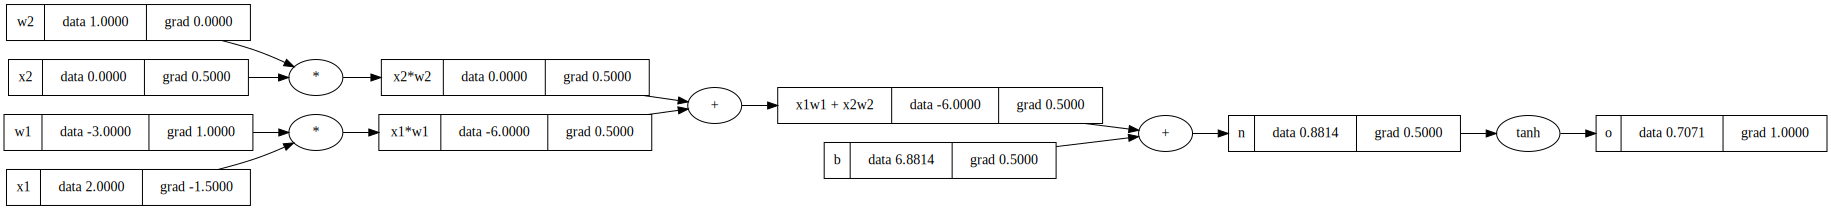

In [32]:
draw_dot(o)

Now all we need to do is hide this functionality! It's just like redstone :P

# Updated Value Object

To make the topo call clean :)

In [36]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(data=self.data + other.data, _children=(self, other),  _op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(data=self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t, _children=(self, ), _op='tanh')

        def _backward():
            self.grad = 1 - t**2 * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        """
        Our hidden topo sort
        """
        topo = []
        visited = set()
        def build_topo(v):
            """
            Starting at some root node (in our case the output), we go through all of its kids and lay them out from left to right
        
            What this does is calling _backward() on all of the nodes in a topological order
            """
            if v not in visited:
                visited.add(v)
                for child in v._prev: # you can think of v._prev as what the root (or current) node point to - the resulting topo is a little backwards, but we are doing back prop after all!
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

Let's redefine our example and re-run it with the new `backward` method

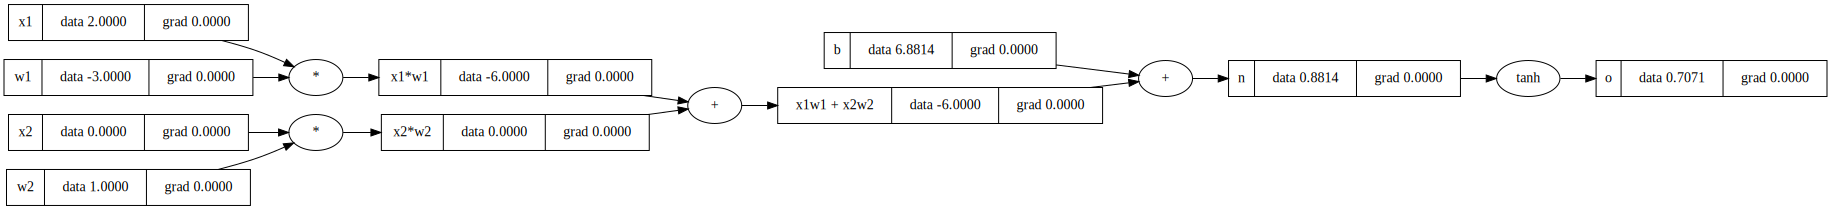

In [37]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 (the synaptic strength for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# summation of our weighted inputs with bias (x1w1 + x2w2 + b)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # n is the raw activation of the cell body - without the activation function

o = n.tanh(); o.label = 'o'
draw_dot(o)

And now with backprop automated for us:

In [38]:
o.backward()

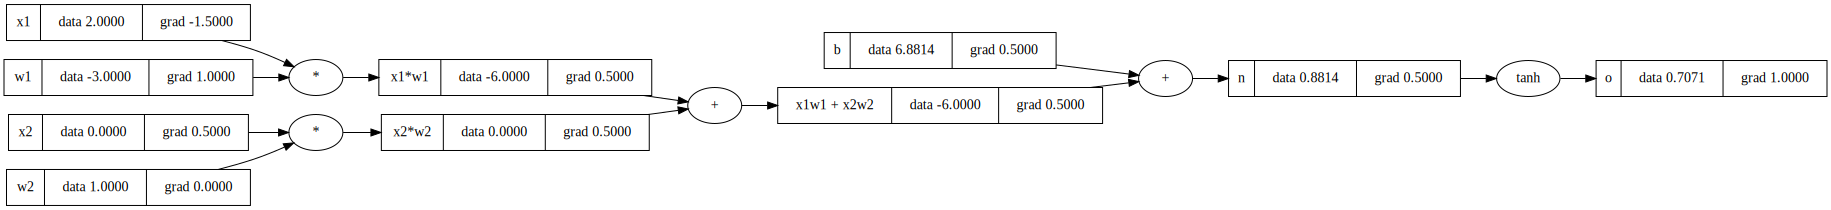

In [39]:
draw_dot(o)

That is backpropagation! Although, just for one neuron...

## But wait... a bug?!?!?

The simplest case that shows the bug:

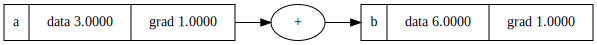

In [40]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

There are two arrows on top of each other in the graph above.

The forward pass works. `b` is just `a + a` which is `6`.

However, the backpropagation fails... `db/da = d(a + a)/da = d(2a)/da = 2`. We are not taking into account coefficients for our input terms. What's happening here is that `_backward` does not take into account the case that `self` and `other` are the exact same object.

In [ ]:
left off at 1:24:20